<a href="https://colab.research.google.com/github/srihari-humbarwadi/image_colorization_gan_tf2.0/blob/master/model/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install tensorflow-gpu==2.0.0
import logging
logger = logging.getLogger("tensorflow")
logger.setLevel(logging.INFO)

from glob import glob
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imread, imsave
from skimage.transform import resize
import tensorflow as tf
from tqdm import tqdm_notebook

print('TensorFlow', tf.__version__)
print('Executing eagerly =>', tf.executing_eagerly())
drive.mount('/gdrive')
!nvidia-smi

TensorFlow 2.0.0
Executing eagerly => True
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
Thu Oct 31 16:33:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M

In [4]:
!apt install aria2 -y
!aria2c -j 16 "http://files.fast.ai/data/imagenet-sample-train.tar.gz"
!tar -xvf imagenet-sample-train.tar.gz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libc-ares2
The following NEW packages will be installed:
  aria2 libc-ares2
0 upgraded, 2 newly installed, 0 to remove and 28 not upgraded.
Need to get 1,274 kB of archives.
After this operation, 4,912 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libc-ares2 amd64 1.14.0-1 [37.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 aria2 amd64 1.33.1-1 [1,236 kB]
Fetched 1,274 kB in 1s (1,253 kB/s)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 132681 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.14.0-1_amd64.deb ...
Unpacking libc-ares2:amd64 (1.14.0-1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../aria2_1.33.1-1_amd64.deb ...
Unpacking aria2 (1.33.1-1) ...
Processing triggers f

In [0]:
def imshow(image, title=None):
    plt.figure(figsize=(16, 9))
    plt.axis('off')
    if title:
        plt.title(title)
    cmap = None if image.ndim == 3 else 'gray'
    plt.imshow(image, cmap=cmap)
    
def downscale_conv2D(tensor, n_filters, kernel_size=4, strides=2, name=None, use_bn=True):
    _x = tf.keras.layers.Conv2D(filters=n_filters,
                                kernel_size=kernel_size,
                                strides=strides, 
                                padding='same',
                                use_bias=False,
                                name='downscale_block_' + name + '_conv2d', 
                                activation=None)(tensor)
    if use_bn:
        _x = tf.keras.layers.BatchNormalization(name='downscale_block_' + name + '_bn')(_x)
    _x = tf.keras.layers.LeakyReLU(alpha=0.2, name='downscale_block_' + name + '_lrelu')(_x)
    return _x

def upscale_deconv2d(tensor, n_filters, kernel_size=4, strides=2, name=None):
    _x = tf.keras.layers.Conv2DTranspose(filters=n_filters,
                                         kernel_size=kernel_size,
                                         strides=strides, 
                                         padding='same',
                                         use_bias=False,
                                         name='upscale_block_' + name + '_conv2d', 
                                         activation=None)(tensor)
    _x = tf.keras.layers.BatchNormalization(name='upscale_block_' + name + '_bn')(_x)
    _x = tf.keras.layers.ReLU(name='upscale_block_' + name + '_relu')(_x)
    return _x

def build_generator():
    _input = tf.keras.Input(shape=[256, 256, 1], name='image_input')
    x = downscale_conv2D(_input, 64, strides=1, name='0')
    features = [x]
    for i, n_filters in enumerate([64, 128, 256, 512, 512, 512, 512]):
        x = downscale_conv2D(x, n_filters, name=str(i+1))
        features.append(x)

    for i, n_filters in enumerate([512, 512, 512, 256, 128, 64, 64]):
        x = upscale_deconv2d(x, n_filters, name=str(i+1))
        x = tf.keras.layers.Concatenate()([features[-(i+2)], x])
    _output = tf.keras.layers.Conv2D(filters=3, 
                                     kernel_size=1, 
                                     strides=1, 
                                     padding='same',
                                     name='output_conv2d', 
                                     activation='tanh')(x)
    return tf.keras.Model(inputs=[_input], outputs=[_output], name='Generator')

def build_discriminator():
    _input = tf.keras.Input(shape=[256, 256,  4])
    x = downscale_conv2D(_input, 64, strides=2, name='0', use_bn=False)
    x = downscale_conv2D(x, 128, strides=2, name='1')
    x = downscale_conv2D(x, 256, strides=2, name='2')
    x = downscale_conv2D(x, 512, strides=1, name='3')
    _output = tf.keras.layers.Conv2D(filters=1,
                                     kernel_size=1, 
                                     strides=1, 
                                     padding='same', 
                                     name='output_conv2d', 
                                     activation=None)(x)
    return tf.keras.Model(inputs=[_input], outputs=[_output], name='Discriminator')

In [0]:
class Colorizer:
    def __init__(self, config):
        super(Colorizer, self).__init__()
        self.distribute_strategy = config['distribute_strategy']
        self.epochs = config['epochs']
        self.batch_size = config['batch_size']
        self.d_lr = config['d_lr']
        self.g_lr = config['g_lr']
        self.image_list = config['image_list']
        self.model_dir = config['model_dir']
        self.tensorboard_log_dir = config['tensorboard_log_dir']
        self.checkpoint_prefix = config['checkpoint_prefix']
        self.restore_parameters = config['restore_parameters']
        self.build_dataset()
        self.initialize_loss_objects()
        self.initialize_metrics()
        self.build_models()
        self.create_optimizers()
        self.create_checkpoint_manager()
        self.create_summary_writer()
        
    def build_models(self):
        logger.info('++++Building Models')
        with self.distribute_strategy.scope():
            self.generator = build_generator()
            self.discriminator = build_discriminator()

    def build_dataset(self):
        logger.info('++++Building Dataset')
        self.steps = len(self.image_list) // self.batch_size
        def preprocess_input(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, size=[256, 256])
            
            def _preprocess_input(image):
                image_n = np.uint8(image.numpy())
                image_gray = np.float32(rgb2gray(image_n.copy()))
                image_lab = np.float32(rgb2lab(image_n.copy()))
                image_gray =  image_gray*2 - 1
                image_lab = tf.stack([
                    image_lab[..., 0]/50 - 1,
                    image_lab[..., 1]/110,
                    image_lab[..., 2]/110,
                ], axis=-1)
                return image_gray[..., None], image_lab
            return tf.py_function(_preprocess_input, [image], [tf.float32, tf.float32])
        
        with self.distribute_strategy.scope():
            self.dataset = tf.data.Dataset.from_tensor_slices(self.image_list)
            self.dataset = self.dataset.map(preprocess_input,
                                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
            self.dataset = self.dataset.batch(self.batch_size, drop_remainder=True)
            self.dataset = self.dataset.prefetch(tf.data.experimental.AUTOTUNE)
            self.dataset = self.distribute_strategy.experimental_distribute_dataset(self.dataset)
        
    def create_optimizers(self):
        logger.info('++++Creating Optimizers')
        with self.distribute_strategy.scope():
            self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=self.d_lr, beta_1=0.5)
            self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=self.g_lr, beta_1=0.5)  
    
    def initialize_loss_objects(self):
        with self.distribute_strategy.scope():
            self.bce_smooth = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                                 label_smoothing=0.1,
                                                                 reduction=tf.keras.losses.Reduction.NONE)
            self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                          reduction=tf.keras.losses.Reduction.NONE)     
    
    def initialize_metrics(self):
        with self.distribute_strategy.scope():
            self.generator_loss = tf.keras.metrics.Mean(name='generator_loss')
            self.discriminator_loss_real = tf.keras.metrics.Mean(name='discriminator_loss_real')   
            self.discriminator_loss_fake = tf.keras.metrics.Mean(name='discriminator_loss_fake')
            self.psnr = tf.keras.metrics.Mean(name='PSNR')
            
    def create_checkpoint_manager(self):
        with self.distribute_strategy.scope():
            self.checkpoint = tf.train.Checkpoint(generator=self.generator, 
                                                  discriminator=self.discriminator, 
                                                  g_optimizer=self.g_optimizer,
                                                  d_optimizer=self.d_optimizer)
            if self.restore_parameters:
                logger.info('++++Restoring Parameters')
                self.generator.build((256, 256, 1))
                self.discriminator.build((1, 256, 256, 4))
                latest_checkpoint = tf.train.latest_checkpoint(self.model_dir)
                self.restore_status = self.checkpoint.restore(latest_checkpoint)
                        
    def create_summary_writer(self):
        self.summary_writer = tf.summary.create_file_writer(logdir=self.tensorboard_log_dir)
            

    def loss_G(self, fake_logits, real, fake, gamma=100):
        bce_loss = tf.reduce_mean(self.bce(tf.ones_like(fake_logits),
                                           fake_logits), axis=[1, 2])
        l1_loss = tf.reduce_mean(tf.abs(real - fake), axis=[1, 2, 3])
        return tf.nn.compute_average_loss(bce_loss + gamma*l1_loss,
                                          global_batch_size=self.batch_size)

    def loss_D_real(self, real_logits):
        real_loss = tf.reduce_mean(self.bce_smooth(tf.ones_like(real_logits),
                                                   real_logits), axis=[1, 2])
        return tf.nn.compute_average_loss(real_loss,
                                          global_batch_size=self.batch_size)

    def loss_D_fake(self, fake_logits):
        fake_loss = tf.reduce_mean(self.bce(tf.zeros_like(fake_logits),
                                               fake_logits), axis=[1, 2])
        return tf.nn.compute_average_loss(fake_loss,
                                          global_batch_size=self.batch_size)
    
    def compute_psnr(self, real, fake):
        psnr = tf.image.psnr(real, fake, max_val=1.0)
        return tf.reduce_sum(psnr, axis=0) / self.batch_size
    
    def write_summaries(self, metrics):
        logger.info('++++Writing Summaries')
        d_real_loss, d_fake_loss, g_loss, psnr = tf.split(metrics, num_or_size_splits=4)
        with self.summary_writer.as_default():
            tf.summary.scalar('discriminator_loss_real',
                              d_real_loss[0], step=self.iterations)
            tf.summary.scalar('discriminator_loss_fake',
                              d_fake_loss[0], step=self.iterations)
            tf.summary.scalar('generator_loss',
                              g_loss[0], step=self.iterations)
            tf.summary.scalar('PSNR', psnr[0], step=self.iterations)
            
    def write_checkpoint(self):
        with self.distribute_strategy.scope():
            self.checkpoint.save(os.path.join(self.model_dir,
                                              self.checkpoint_prefix))            
    
    def update_metrics(self, metrics):
        d_real_loss, d_fake_loss, g_loss, psnr = tf.split(metrics, num_or_size_splits=4)
        self.generator_loss.update_state(g_loss)
        self.discriminator_loss_real.update_state(d_real_loss)
        self.discriminator_loss_fake.update_state(d_fake_loss)
        self.psnr.update_state(psnr)
    
    def reset_metrics(self):
        self.generator_loss.reset_states()
        self.discriminator_loss_real.reset_states()
        self.discriminator_loss_fake.reset_states()
        self.psnr.reset_states()
        
    def log_metrics(self):
        metrics_dict = {
            'epoch':self.epoch,
            'batch':self.iterations,
            'generator_loss':np.round(self.generator_loss.result(), 3),
            'discriminator_loss_real':np.round(self.discriminator_loss_real.result(), 3),
            'discriminator_loss_fake':np.round(self.discriminator_loss_fake.result(), 3),
            'psnr':np.round(self.psnr.result(), 3)
        }
        logger.info(metrics_dict)
        
    def train(self):
        logger.info('++++Starting Training Loop')
        if self.restore_parameters:
            self.restore_status.assert_consumed()
            
        @tf.function
        def train_step(grayscale_image, lab_image):
            real_input = tf.concat([grayscale_image, lab_image], axis=-1)
            with tf.GradientTape() as r_tape:
                real_logits = self.discriminator(real_input, training=True)
                d_real_loss = self.loss_D_real(real_logits)
            d_r_gradients = r_tape.gradient(d_real_loss,
                                            self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_r_gradients,
                                                 self.discriminator.trainable_variables))

            with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
                fake_image = self.generator(grayscale_image, training=True)
                fake_input = tf.concat([grayscale_image, fake_image], axis=-1)
                fake_logits = self.discriminator(real_input, training=True)

                d_fake_loss = self.loss_D_fake(fake_logits)
                g_loss = self.loss_G(fake_logits, lab_image, fake_image)
            d_f_gradients = d_tape.gradient(d_fake_loss,
                                            self.discriminator.trainable_variables)
            g_gradients = g_tape.gradient(g_loss,
                                          self.generator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_f_gradients,
                                                 self.discriminator.trainable_variables))
            self.g_optimizer.apply_gradients(zip(g_gradients,
                                                 self.generator.trainable_variables))
            psnr = self.compute_psnr(lab_image, fake_image)
            metrics = tf.stack([d_real_loss, 
                               d_fake_loss, 
                               g_loss, 
                               psnr], axis=-1)
            return tf.reshape(metrics, shape=[1, -1])
    
        @tf.function
        def distributed_train_step(grayscale_image, lab_image):
            per_replica_metrics = self.distribute_strategy.experimental_run_v2(fn=train_step,
                                                                 args=(grayscale_image, lab_image))
            reduced_metrics = self.distribute_strategy.reduce(tf.distribute.ReduceOp.SUM,
                                              per_replica_metrics, axis=0)
            return reduced_metrics
        
        self.epoch = 0
        for _ in range(self.epochs):
            self.iterations = 0
            for grayscale_image, lab_image in self.dataset:
                metrics = distributed_train_step(grayscale_image, lab_image)
                self.update_metrics(metrics)
                self.log_metrics()
                self.iterations += 1
            self.write_summaries(metrics)
            self.reset_metrics()
            self.write_checkpoint()
            self.epoch += 1
                    
                    
    def __call__(self, grayscale_image):
        self.restore_status.assert_consumed()
        assert grayscale_image.ndim == 2
        grayscale_image = resize(grayscale_image, output_shape=(256, 256))
        grayscale_image = grayscale_image[None, ..., None]*2 - 1
        lab_image = self.generator(grayscale_image, training=False)[0]
        lab_image = np.stack([
            (lab_image[..., 0]+1)*50,
            lab_image[..., 1]*110,
            lab_image[..., 2]*110,
        ], axis=-1)
        rgb_image = np.uint8(lab2rgb(lab_image)*255)
        return rgb_image

In [0]:
config = {
    'distribute_strategy':tf.distribute.OneDeviceStrategy(device='/gpu:0'),
    'epochs':200,
    'batch_size':32,
    'd_lr':1e-4,
    'g_lr':1e-4,
    'image_list':glob('train/*/*'),
    'model_dir':'/gdrive/My\ Drive/colorizer/model_files',
    'tensorboard_log_dir':'logs',
    'checkpoint_prefix':'ckpt',
    'restore_parameters':False
}
colorizer = Colorizer(config)
colorizer.train()

INFO:tensorflow:++++Building Dataset
INFO:tensorflow:++++Building Models
INFO:tensorflow:++++Creating Optimizers
INFO:tensorflow:++++Starting Training Loop
INFO:tensorflow:{'epoch': 0, 'batch': 0, 'generator_loss': 64.812, 'discriminator_loss_real': 0.619, 'discriminator_loss_fake': 1.261, 'psnr': 2.412}
INFO:tensorflow:{'epoch': 0, 'batch': 1, 'generator_loss': 61.275, 'discriminator_loss_real': 0.677, 'discriminator_loss_fake': 1.16, 'psnr': 2.798}
INFO:tensorflow:{'epoch': 0, 'batch': 2, 'generator_loss': 59.18, 'discriminator_loss_real': 0.653, 'discriminator_loss_fake': 1.112, 'psnr': 3.063}
INFO:tensorflow:{'epoch': 0, 'batch': 3, 'generator_loss': 57.121, 'discriminator_loss_real': 0.643, 'discriminator_loss_fake': 1.073, 'psnr': 3.372}
INFO:tensorflow:{'epoch': 0, 'batch': 4, 'generator_loss': 55.286, 'discriminator_loss_real': 0.637, 'discriminator_loss_fake': 1.052, 'psnr': 3.658}
INFO:tensorflow:{'epoch': 0, 'batch': 5, 'generator_loss': 53.103, 'discriminator_loss_real': 0.

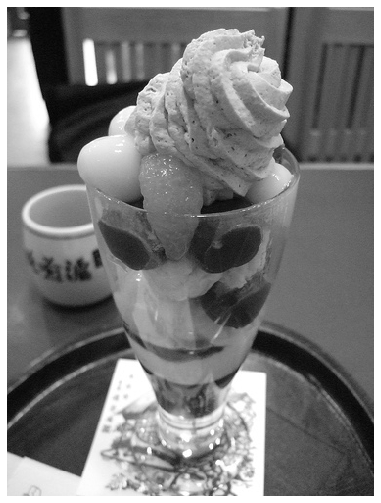

In [0]:
image = imread(glob('train/*/*')[15], as_gray=True)
colored_image = colorizer(image)
imshow(image)
# imshow(colored_image)